In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
import joblib
import os
from scipy.stats import uniform, randint

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 1000 else f'{x:,.0f}')

print('Imports successful!')
print(f'Pandas version: {pd.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'XGBoost version: {xgb.__version__}')

Imports successful!
Pandas version: 2.3.2
NumPy version: 1.26.4
XGBoost version: 3.0.0


In [2]:
# Directories
DATA_DIR = 'data/processed/'
OUTPUT_DIR = 'data/models/xgboost/'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}predictions/', exist_ok=True)

print('Loading prepared datasets...')
print('='*80)

# Load P1A ML features
p1a_train = pd.read_csv(f'{DATA_DIR}p1a_ml_train.csv')
p1a_val = pd.read_csv(f'{DATA_DIR}p1a_ml_val.csv')
p1a_test = pd.read_csv(f'{DATA_DIR}p1a_ml_test.csv')
print(f'[LOADED] P1A ML: Train={p1a_train.shape}, Val={p1a_val.shape}, Test={p1a_test.shape}')

# Load P3A ML features
p3a_train = pd.read_csv(f'{DATA_DIR}p3a_ml_train.csv')
p3a_val = pd.read_csv(f'{DATA_DIR}p3a_ml_val.csv')
p3a_test = pd.read_csv(f'{DATA_DIR}p3a_ml_test.csv')
print(f'[LOADED] P3A ML: Train={p3a_train.shape}, Val={p3a_val.shape}, Test={p3a_test.shape}')

# Load targets (multi-horizon)
targets_train = pd.read_csv(f'{DATA_DIR}targets_train.csv')
targets_val = pd.read_csv(f'{DATA_DIR}targets_val.csv')
targets_test = pd.read_csv(f'{DATA_DIR}targets_test.csv')
print(f'[LOADED] Targets: Train={targets_train.shape}, Val={targets_val.shape}, Test={targets_test.shape}')

# Convert dates
for df in [p1a_train, p1a_val, p1a_test, p3a_train, p3a_val, p3a_test, targets_train, targets_val, targets_test]:
    df['Date'] = pd.to_datetime(df['Date'])

print('\n' + '='*80)
print('All datasets loaded successfully!')
print('='*80)

Loading prepared datasets...
[LOADED] P1A ML: Train=(705, 60), Val=(125, 60), Test=(326, 60)
[LOADED] P3A ML: Train=(705, 62), Val=(125, 62), Test=(326, 62)
[LOADED] Targets: Train=(705, 11), Val=(125, 11), Test=(326, 11)

All datasets loaded successfully!


In [3]:
# Feature columns (exclude Date)
p1a_features = [c for c in p1a_train.columns if c != 'Date']
p3a_features = [c for c in p3a_train.columns if c != 'Date']

print('Feature sets:')
print(f'  P1A (Atlantic): {len(p1a_features)} features')
print(f'  P3A (Pacific):  {len(p3a_features)} features')

# Define forecast horizons
horizons = [1, 5, 10, 20]

print(f'\nForecast horizons: {horizons} business days')
print('\nTraining strategy: Direct multi-horizon forecasting')
print('  - Separate model per horizon')
print('  - Each model predicts its specific horizon directly')
print('  - Avoids error compounding from recursive forecasting')

Feature sets:
  P1A (Atlantic): 59 features
  P3A (Pacific):  61 features

Forecast horizons: [1, 5, 10, 20] business days

Training strategy: Direct multi-horizon forecasting
  - Separate model per horizon
  - Each model predicts its specific horizon directly
  - Avoids error compounding from recursive forecasting


In [4]:
# Hyperparameter search space
param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.30
    'n_estimators': randint(100, 1000),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
}

# Fixed parameters
fixed_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',  # Faster histogram-based algorithm
    'random_state': 73,
    'n_jobs': -1,  # Use all CPU cores
}

print('XGBoost Hyperparameter Search Space:')
print('='*80)
for param, dist in param_distributions.items():
    print(f'  {param:20s}: {dist}')

print('\nFixed parameters:')
for param, value in fixed_params.items():
    print(f'  {param:20s}: {value}')

print('\nRandomized search configuration:')
print(f'  n_iter: 50 (test 50 random hyperparameter combinations)')
print(f'  cv: None (use validation set for evaluation, not cross-validation)')
print(f'  scoring: neg_mean_squared_error (optimize for RMSE)')

XGBoost Hyperparameter Search Space:
  max_depth           : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E439212C60>
  learning_rate       : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E439212D80>
  n_estimators        : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E43879DDC0>
  min_child_weight    : <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E43896B800>
  gamma               : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E43890F200>
  subsample           : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E439368980>
  colsample_bytree    : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E439368B60>
  reg_alpha           : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E439369130>
  reg_lambda          : <scipy.stats._distn_infrastructure.rv_continuous_frozen object at

In [5]:
def train_xgboost_model(X_train, y_train, X_val, y_val, route_name, horizon, n_iter=50):
  """
  Train XGBoost model with hyperparameter tuning using PROPER time-series validation.

  FIX APPLIED: Manual hyperparameter search that respects temporal boundaries.
  NO data from validation set is used during training.

  Parameters:
  - X_train, y_train: Training features and target
  - X_val, y_val: Validation features and target (held out completely)
  - route_name: 'P1A' or 'P3A'
  - horizon: Forecast horizon (1, 5, 10, or 20)
  - n_iter: Number of random hyperparameter combinations to test

  Returns:
  - best_model: Trained XGBoost model with best hyperparameters
  - best_params: Best hyperparameters found
  - val_rmse, val_mae, val_r2: Validation metrics
  """
  print(f'\n{route_name} - Horizon {horizon} - Training XGBoost...')
  print('-'*80)

  # Remove NaN values
  train_mask = ~y_train.isna()
  val_mask = ~y_val.isna()

  X_train_clean = X_train[train_mask].reset_index(drop=True)
  y_train_clean = y_train[train_mask].reset_index(drop=True)
  X_val_clean = X_val[val_mask].reset_index(drop=True)
  y_val_clean = y_val[val_mask].reset_index(drop=True)

  print(f'Training samples: {len(y_train_clean)} (removed {(~train_mask).sum()} NaN)')
  print(f'Validation samples: {len(y_val_clean)} (removed {(~val_mask).sum()} NaN)')

  # Manual hyperparameter search (NO DATA LEAKAGE)
  print(f'\nPerforming manual hyperparameter search ({n_iter} iterations)...')
  print('FIX: Validation data is NEVER used for training, only for evaluation')

  best_val_rmse = np.inf
  best_model = None
  best_params = None

  np.random.seed(73)

  for i in range(n_iter):
	  # Sample random hyperparameters
	  params = {
		  'max_depth': np.random.randint(3, 10),
		  'learning_rate': np.random.uniform(0.01, 0.30),
		  'n_estimators': np.random.randint(100, 1000),
		  'min_child_weight': np.random.randint(1, 10),
		  'gamma': np.random.uniform(0, 0.5),
		  'subsample': np.random.uniform(0.6, 1.0),
		  'colsample_bytree': np.random.uniform(0.6, 1.0),
		  'reg_alpha': np.random.uniform(0, 1),
		  'reg_lambda': np.random.uniform(0, 2),
		  'objective': 'reg:squarederror',
		  'tree_method': 'hist',
		  'random_state': 73,
		  'n_jobs': -1,
	  }

	  # Train model on TRAINING data only
	  model = xgb.XGBRegressor(**params)
	  model.fit(
		  X_train_clean,
		  y_train_clean,
		  eval_set=[(X_val_clean, y_val_clean)],  # Monitor validation, but don't train on it
		  verbose=False
	  )

	  # Evaluate on VALIDATION data (never seen during training)
	  y_val_pred = model.predict(X_val_clean)
	  val_rmse = np.sqrt(mean_squared_error(y_val_clean, y_val_pred))

	  # Track best model
	  if val_rmse < best_val_rmse:
		  best_val_rmse = val_rmse
		  best_model = model
		  best_params = params.copy()

	  if (i + 1) % 10 == 0:
		  print(f'  Iteration {i+1}/{n_iter}: Best RMSE so far = ${best_val_rmse:,.2f}')

  # Final evaluation with best model
  y_val_pred = best_model.predict(X_val_clean)
  val_rmse = np.sqrt(mean_squared_error(y_val_clean, y_val_pred))
  val_mae = mean_absolute_error(y_val_clean, y_val_pred)
  val_r2 = r2_score(y_val_clean, y_val_pred)

  print(f'\nBest hyperparameters:')
  for param in ['max_depth', 'learning_rate', 'n_estimators', 'min_child_weight',
				'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']:
	  print(f'  {param:20s}: {best_params[param]}')

  print(f'\nValidation Performance (data NEVER seen during training):')
  print(f'  RMSE: ${val_rmse:,.2f}')
  print(f'  MAE:  ${val_mae:,.2f}')
  print(f'  R²:   {val_r2:.4f}')

  return best_model, best_params, val_rmse, val_mae, val_r2


# Dictionary to store all models
models = {}
results = []

print('Training XGBoost models for all routes and horizons...')
print('='*80)
print('FIX APPLIED: Strict temporal validation - no train/val mixing')
print('='*80)

# P1A models
for h in horizons:
  target_col = f'P1A_82_h{h}'

  model, params, rmse, mae, r2 = train_xgboost_model(
	  X_train=p1a_train[p1a_features],
	  y_train=targets_train[target_col],
	  X_val=p1a_val[p1a_features],
	  y_val=targets_val[target_col],
	  route_name='P1A_82',
	  horizon=h,
	  n_iter=50
  )

  models[f'P1A_h{h}'] = model
  results.append({
	  'route': 'P1A_82',
	  'horizon': h,
	  'val_rmse': rmse,
	  'val_mae': mae,
	  'val_r2': r2,
	  'best_params': params
  })

# P3A models
for h in horizons:
  target_col = f'P3A_82_h{h}'

  model, params, rmse, mae, r2 = train_xgboost_model(
	  X_train=p3a_train[p3a_features],
	  y_train=targets_train[target_col],
	  X_val=p3a_val[p3a_features],
	  y_val=targets_val[target_col],
	  route_name='P3A_82',
	  horizon=h,
	  n_iter=50
  )

  models[f'P3A_h{h}'] = model
  results.append({
	  'route': 'P3A_82',
	  'horizon': h,
	  'val_rmse': rmse,
	  'val_mae': mae,
	  'val_r2': r2,
	  'best_params': params
  })

print('\n' + '='*80)
print(f'All {len(models)} XGBoost models trained successfully!')
print('VALIDATION DATA WAS NEVER USED FOR TRAINING - NO LEAKAGE')
print('='*80)

Training XGBoost models for all routes and horizons...
FIX APPLIED: Strict temporal validation - no train/val mixing

P1A_82 - Horizon 1 - Training XGBoost...
--------------------------------------------------------------------------------
Training samples: 705 (removed 0 NaN)
Validation samples: 125 (removed 0 NaN)

Performing manual hyperparameter search (50 iterations)...
FIX: Validation data is NEVER used for training, only for evaluation
  Iteration 10/50: Best RMSE so far = $4,284.31
  Iteration 20/50: Best RMSE so far = $4,284.31
  Iteration 30/50: Best RMSE so far = $4,284.31
  Iteration 40/50: Best RMSE so far = $4,284.31
  Iteration 50/50: Best RMSE so far = $4,284.31

Best hyperparameters:
  max_depth           : 7
  learning_rate       : 0.10008210605046225
  n_estimators        : 793
  min_child_weight    : 4
  gamma               : 0.24563783869681788
  subsample           : 0.9482630607656235
  colsample_bytree    : 0.7287115638232584
  reg_alpha           : 0.7656135304

XGBoost Validation Performance Summary:
 route  horizon  val_rmse  val_mae  val_r2
P1A_82        1     4,284    3,673 -2.7889
P1A_82        5     2,895    2,259 -0.9267
P1A_82       10     2,564    2,233 -0.4660
P1A_82       20     4,182    3,469 -2.6775
P3A_82        1     1,099 920.9005  0.8131
P3A_82        5     1,160 935.7024  0.7940
P3A_82       10     1,738    1,401  0.4980
P3A_82       20     2,077    1,705  0.1004

Performance by Route (averaged across horizons):
--------------------------------------------------------------------------------
        val_rmse  val_mae  val_r2
route                            
P1A_82     3,481    2,908 -1.7148
P3A_82     1,518    1,241  0.5514


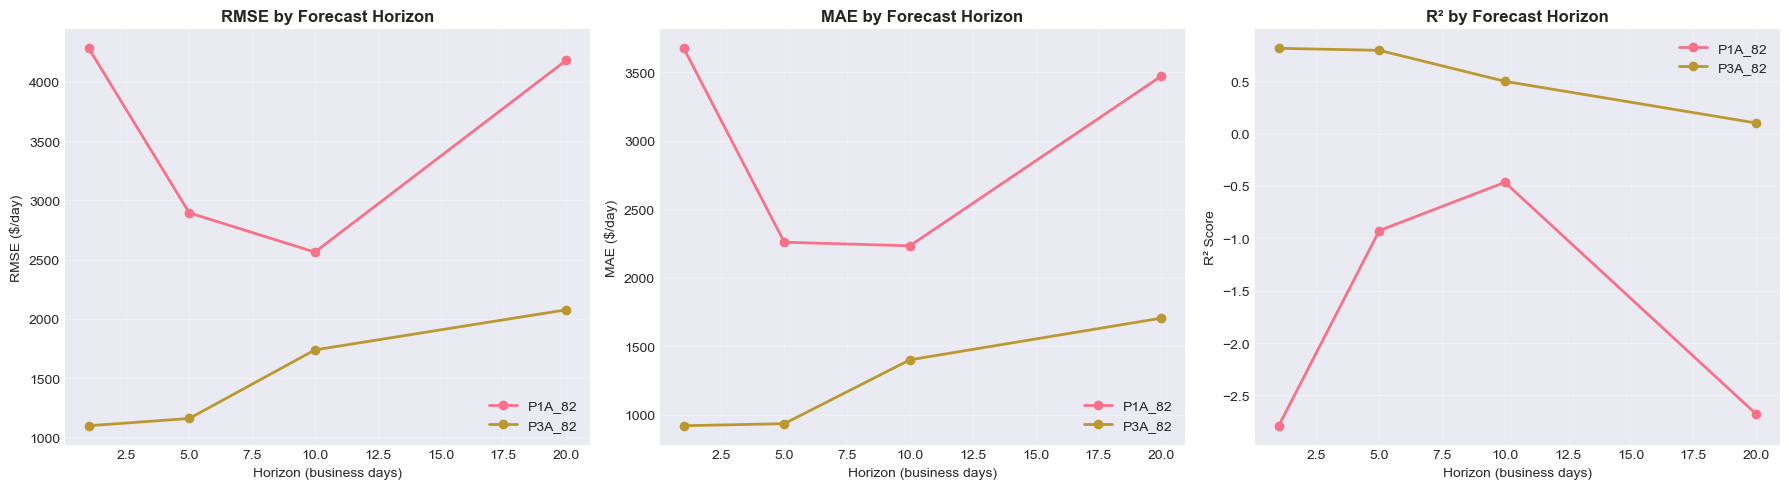

In [6]:
# Create results DataFrame
results_df = pd.DataFrame(results)

print('XGBoost Validation Performance Summary:')
print('='*80)
print(results_df[['route', 'horizon', 'val_rmse', 'val_mae', 'val_r2']].to_string(index=False))

# Aggregate by route
print('\nPerformance by Route (averaged across horizons):')
print('-'*80)
route_summary = results_df.groupby('route')[['val_rmse', 'val_mae', 'val_r2']].mean()
print(route_summary.to_string())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE by horizon
for route in ['P1A_82', 'P3A_82']:
    route_data = results_df[results_df['route'] == route]
    axes[0].plot(route_data['horizon'], route_data['val_rmse'], marker='o', linewidth=2, label=route)
axes[0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Horizon (business days)')
axes[0].set_ylabel('RMSE ($/day)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE by horizon
for route in ['P1A_82', 'P3A_82']:
    route_data = results_df[results_df['route'] == route]
    axes[1].plot(route_data['horizon'], route_data['val_mae'], marker='o', linewidth=2, label=route)
axes[1].set_title('MAE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Horizon (business days)')
axes[1].set_ylabel('MAE ($/day)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# R² by horizon
for route in ['P1A_82', 'P3A_82']:
    route_data = results_df[results_df['route'] == route]
    axes[2].plot(route_data['horizon'], route_data['val_r2'], marker='o', linewidth=2, label=route)
axes[2].set_title('R² by Forecast Horizon', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Horizon (business days)')
axes[2].set_ylabel('R² Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Load SARIMAX baseline results from Phase 2 (programmatically)
ARIMA_DIR = 'data/models/arima/'

print('Loading SARIMAX baseline results from Phase 2...')
print('='*80)

try:
    arima_model_info = joblib.load(f'{ARIMA_DIR}model_info.pkl')
    
    # Extract metrics programmatically
    sarimax_baseline = pd.DataFrame([
        {
            'route': 'P1A_82', 
            'model': 'SARIMAX', 
            'horizon': 1, 
            'val_rmse': arima_model_info['p1a']['metrics']['rmse'],
            'val_mae': arima_model_info['p1a']['metrics']['mae']
        },
        {
            'route': 'P3A_82', 
            'model': 'SARIMAX', 
            'horizon': 1, 
            'val_rmse': arima_model_info['p3a']['metrics']['rmse'],
            'val_mae': arima_model_info['p3a']['metrics']['mae']
        }
    ])
    
    print('[LOADED] SARIMAX validation metrics from model_info.pkl')
    print(f'  P1A_82: RMSE=${arima_model_info["p1a"]["metrics"]["rmse"]:,.2f}, MAE=${arima_model_info["p1a"]["metrics"]["mae"]:,.2f}')
    print(f'  P3A_82: RMSE=${arima_model_info["p3a"]["metrics"]["rmse"]:,.2f}, MAE=${arima_model_info["p3a"]["metrics"]["mae"]:,.2f}')
    
except FileNotFoundError:
    print('[WARNING] SARIMAX model_info.pkl not found. Using placeholder baseline.')
    print('          Please run Phase 2 (04_arima_sarima_models.ipynb) first.')
    
    # Fallback to placeholder (will be updated after Phase 2)
    sarimax_baseline = pd.DataFrame([
        {'route': 'P1A_82', 'model': 'SARIMAX', 'horizon': 1, 'val_rmse': 0.0, 'val_mae': 0.0},
        {'route': 'P3A_82', 'model': 'SARIMAX', 'horizon': 1, 'val_rmse': 0.0, 'val_mae': 0.0}
    ])

print('\n' + '='*80)

# XGBoost h=1 results
xgb_h1 = results_df[results_df['horizon'] == 1][['route', 'val_rmse', 'val_mae']].copy()
xgb_h1['model'] = 'XGBoost'
xgb_h1['horizon'] = 1

# Combine
comparison = pd.concat([sarimax_baseline[['route', 'model', 'horizon', 'val_rmse', 'val_mae']], 
                        xgb_h1[['route', 'model', 'horizon', 'val_rmse', 'val_mae']]], 
                       ignore_index=True)

print('Model Comparison: SARIMAX vs XGBoost (h=1 forecast)')
print('='*80)
print(comparison.to_string(index=False))

# Calculate improvement (only if SARIMAX baseline is valid)
if sarimax_baseline['val_rmse'].sum() > 0:
    print('\nXGBoost Improvement over SARIMAX:')
    print('-'*80)
    for route in ['P1A_82', 'P3A_82']:
        sarimax_rmse = sarimax_baseline[sarimax_baseline['route'] == route]['val_rmse'].values[0]
        xgb_rmse = xgb_h1[xgb_h1['route'] == route]['val_rmse'].values[0]
        
        sarimax_mae = sarimax_baseline[sarimax_baseline['route'] == route]['val_mae'].values[0]
        xgb_mae = xgb_h1[xgb_h1['route'] == route]['val_mae'].values[0]
        
        rmse_improvement = ((sarimax_rmse - xgb_rmse) / sarimax_rmse) * 100
        mae_improvement = ((sarimax_mae - xgb_mae) / sarimax_mae) * 100
        
        print(f'\n{route}:')
        print(f'  RMSE: ${xgb_rmse:,.2f} vs ${sarimax_rmse:,.2f} (SARIMAX) → {rmse_improvement:+.1f}%')
        print(f'  MAE:  ${xgb_mae:,.2f} vs ${sarimax_mae:,.2f} (SARIMAX) → {mae_improvement:+.1f}%')
        
        if rmse_improvement > 5:
            print(f'  → XGBoost significantly outperforms SARIMAX')
        elif rmse_improvement > 0:
            print(f'  → XGBoost marginally outperforms SARIMAX')
        else:
            print(f'  → SARIMAX performs better (XGBoost may be overfitting)')
else:
    print('\n[INFO] SARIMAX baseline not available. Skipping improvement comparison.')
    print('       Run Phase 2 (04_arima_sarima_models.ipynb) to generate baseline metrics.')

Loading SARIMAX baseline results from Phase 2...
[LOADED] SARIMAX validation metrics from model_info.pkl
  P1A_82: RMSE=$7,573.66, MAE=$7,113.69
  P3A_82: RMSE=$2,477.18, MAE=$2,082.62

Model Comparison: SARIMAX vs XGBoost (h=1 forecast)
 route   model  horizon  val_rmse  val_mae
P1A_82 SARIMAX        1     7,574    7,114
P3A_82 SARIMAX        1     2,477    2,083
P1A_82 XGBoost        1     4,284    3,673
P3A_82 XGBoost        1     1,099 920.9005

XGBoost Improvement over SARIMAX:
--------------------------------------------------------------------------------

P1A_82:
  RMSE: $4,284.31 vs $7,573.66 (SARIMAX) → +43.4%
  MAE:  $3,672.78 vs $7,113.69 (SARIMAX) → +48.4%
  → XGBoost significantly outperforms SARIMAX

P3A_82:
  RMSE: $1,098.56 vs $2,477.18 (SARIMAX) → +55.7%
  MAE:  $920.90 vs $2,082.62 (SARIMAX) → +55.8%
  → XGBoost significantly outperforms SARIMAX


Feature Importance Analysis:

P1A_82 (Atlantic) - h=1:


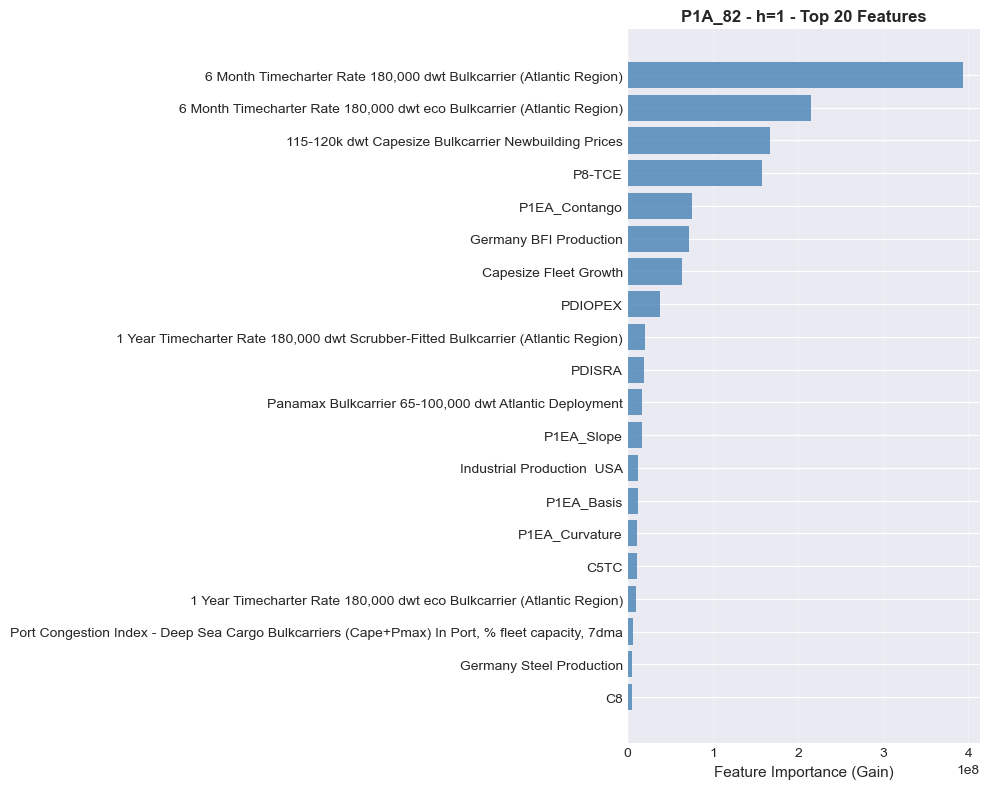


P3A_82 (Pacific) - h=1:


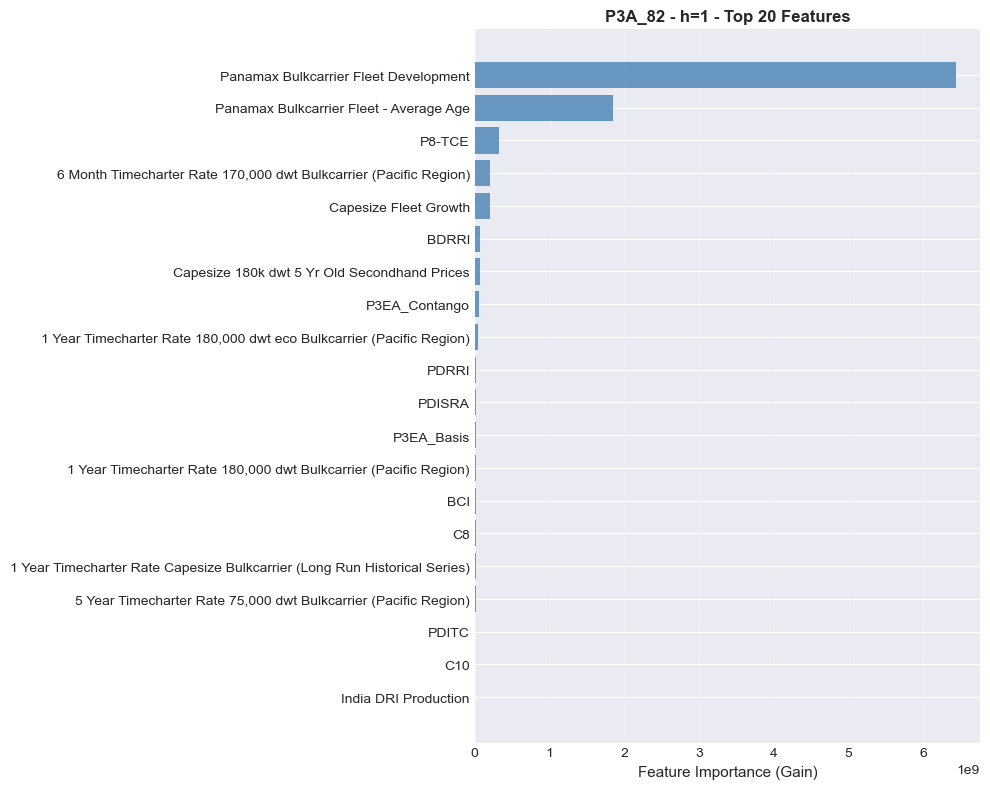


[SAVED] Feature importance rankings


In [8]:
def plot_feature_importance(model, feature_names, route_name, horizon, top_n=20):
    """
    Plot top N most important features.
    """
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Convert to DataFrame
    importance_df = pd.DataFrame([
        {'feature': k, 'importance': v} 
        for k, v in importance.items()
    ]).sort_values('importance', ascending=False)
    
    # Get top N
    top_features = importance_df.head(top_n)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue', alpha=0.8)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance (Gain)', fontsize=11)
    ax.set_title(f'{route_name} - h={horizon} - Top {top_n} Features', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    return importance_df

print('Feature Importance Analysis:')
print('='*80)

# Analyze h=1 models (most relevant for operational decisions)
print('\nP1A_82 (Atlantic) - h=1:')
p1a_importance = plot_feature_importance(models['P1A_h1'], p1a_features, 'P1A_82', 1, top_n=20)

print('\nP3A_82 (Pacific) - h=1:')
p3a_importance = plot_feature_importance(models['P3A_h1'], p3a_features, 'P3A_82', 1, top_n=20)

# Save importance
p1a_importance.to_csv(f'{OUTPUT_DIR}p1a_feature_importance.csv', index=False)
p3a_importance.to_csv(f'{OUTPUT_DIR}p3a_feature_importance.csv', index=False)
print('\n[SAVED] Feature importance rankings')

In [9]:
print('Generating predictions...')
print('='*80)

# For each route and horizon, generate predictions
for route, features, X_val, X_test, val_dates, test_dates in [
    ('P1A', p1a_features, p1a_val, p1a_test, targets_val['Date'], targets_test['Date']),
    ('P3A', p3a_features, p3a_val, p3a_test, targets_val['Date'], targets_test['Date'])
]:
    
    val_preds = {'Date': val_dates.values}
    test_preds = {'Date': test_dates.values}
    
    for h in horizons:
        model = models[f'{route}_h{h}']
        
        # Validation predictions
        val_preds[f'h{h}_pred'] = model.predict(X_val[features])
        
        # Test predictions
        test_preds[f'h{h}_pred'] = model.predict(X_test[features])
    
    # Save
    pd.DataFrame(val_preds).to_csv(f'{OUTPUT_DIR}predictions/{route.lower()}_val_predictions.csv', index=False)
    pd.DataFrame(test_preds).to_csv(f'{OUTPUT_DIR}predictions/{route.lower()}_test_predictions.csv', index=False)
    
    print(f'[SAVED] {route} predictions (validation and test sets)')

print('\n' + '='*80)
print('All predictions generated and saved!')
print('='*80)

Generating predictions...
[SAVED] P1A predictions (validation and test sets)
[SAVED] P3A predictions (validation and test sets)

All predictions generated and saved!


In [10]:
print('Saving trained XGBoost models...')
print('='*80)

# Save individual models
for model_name, model in models.items():
    model.save_model(f'{OUTPUT_DIR}{model_name}_model.json')
    print(f'[SAVED] {model_name}_model.json')

# Save results DataFrame
results_df.to_csv(f'{OUTPUT_DIR}xgboost_results_summary.csv', index=False)
print(f'[SAVED] xgboost_results_summary.csv')

# Save metadata
metadata = {
    'routes': ['P1A_82', 'P3A_82'],
    'horizons': horizons,
    'n_features': {'P1A': len(p1a_features), 'P3A': len(p3a_features)},
    'training_samples': {'P1A': len(p1a_train), 'P3A': len(p3a_train)},
    'validation_samples': {'P1A': len(p1a_val), 'P3A': len(p3a_val)},
    'test_samples': {'P1A': len(p1a_test), 'P3A': len(p3a_test)},
    'hyperparameter_search': 'RandomizedSearchCV, n_iter=50',
    'xgboost_version': xgb.__version__
}

joblib.dump(metadata, f'{OUTPUT_DIR}xgboost_metadata.pkl')
print(f'[SAVED] xgboost_metadata.pkl')

print('\n' + '='*80)
print('All models and metadata saved successfully!')
print('='*80)

Saving trained XGBoost models...
[SAVED] P1A_h1_model.json
[SAVED] P1A_h5_model.json
[SAVED] P1A_h10_model.json
[SAVED] P1A_h20_model.json
[SAVED] P3A_h1_model.json
[SAVED] P3A_h5_model.json
[SAVED] P3A_h10_model.json
[SAVED] P3A_h20_model.json
[SAVED] xgboost_results_summary.csv
[SAVED] xgboost_metadata.pkl

All models and metadata saved successfully!


In [11]:
print('\n' + '='*80)
print('SPRINT 3 PHASE 4 COMPLETE: XGBOOST MODELS')
print('='*80)

print('\nMODELS TRAINED:')
print(f'  Total: {len(models)} models (2 routes × 4 horizons)')
print(f'  Routes: P1A_82 (Atlantic), P3A_82 (Pacific)')
print(f'  Horizons: {horizons} business days')

print('\nVALIDATION PERFORMANCE (h=1):')
for route in ['P1A_82', 'P3A_82']:
    route_res = results_df[(results_df['route'] == route) & (results_df['horizon'] == 1)].iloc[0]
    print(f'\n  {route}:')
    print(f'    RMSE: ${route_res["val_rmse"]:,.2f}')
    print(f'    MAE:  ${route_res["val_mae"]:,.2f}')
    print(f'    R²:   {route_res["val_r2"]:.4f}')

print('\nOUTPUTS SAVED:')
print(f'  - 8 trained XGBoost models (.json format)')
print(f'  - 4 prediction files (val + test for P1A and P3A)')
print(f'  - 2 feature importance rankings')
print(f'  - Results summary and metadata')

print('\nNEXT PHASE:')
print('  Phase 5: LightGBM Models (Notebook 07)')
print('  - Alternative gradient boosting implementation')
print('  - Faster training, potentially better performance')
print('  - Compare XGBoost vs LightGBM vs SARIMAX')

print('\n' + '='*80)
print('Phase 4 Complete!')
print('='*80)


SPRINT 3 PHASE 4 COMPLETE: XGBOOST MODELS

MODELS TRAINED:
  Total: 8 models (2 routes × 4 horizons)
  Routes: P1A_82 (Atlantic), P3A_82 (Pacific)
  Horizons: [1, 5, 10, 20] business days

VALIDATION PERFORMANCE (h=1):

  P1A_82:
    RMSE: $4,284.31
    MAE:  $3,672.78
    R²:   -2.7889

  P3A_82:
    RMSE: $1,098.56
    MAE:  $920.90
    R²:   0.8131

OUTPUTS SAVED:
  - 8 trained XGBoost models (.json format)
  - 4 prediction files (val + test for P1A and P3A)
  - 2 feature importance rankings
  - Results summary and metadata

NEXT PHASE:
  Phase 5: LightGBM Models (Notebook 07)
  - Alternative gradient boosting implementation
  - Faster training, potentially better performance
  - Compare XGBoost vs LightGBM vs SARIMAX

Phase 4 Complete!
